In [22]:
from __future__ import division 
import sys
import numpy as np
import csv
import pandas as pd
from numba import jit
from Bio.Seq import Seq
from Bio import SeqIO
import Bio.SeqUtils.MeltingTemp as mt
import scipy.io as sio
import xlwt 
from xlwt import Workbook 
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
# function to get sequences
def get_seq(filename, get_header = False):
    records = list(SeqIO.parse(filename, "fasta"))
    records_seq = [i.seq for i in records]
    headers = [i.description for i in records]
    if get_header == True:
        return records_seq, headers
    else:
        return records_seq

In [3]:
seq, head = get_seq('Inputs/Final_New_Proteins.fasta', get_header = True)
N = len(seq)

---
## Process blasting results
If there is already *localkeep_New_Proteins.fasta* and *lib_local.mat*, skip these two steps.
1. In this repository folder, run following commands to blast the local library:  
  
cd Inputs  
tblastn -query Final_New_Proteins_nogap.fasta -subject twist_red_seqs_forblast.an -max_target_seqs 1 -evalue 1e-3 -word_size 6 -outfmt 6 > blast_local2.txt  
  
2. Running following codes to remove sequences without blast results

In [68]:
blast = pd.read_csv("Inputs/blast_local2.txt", sep = '\t', header=None)
Nb = len(blast)

In [8]:
keep = []
blast_head = np.array(blast[0])
for i in range(N):
    if head[i] in blast_head:
        keep.append(i)
len(keep)

8868

In [12]:
blast_new = blast.copy()
blast_new2 = blast_new.loc[~blast_new[0].duplicated(keep='first')] # remove dulicated blast results

# Check header match
for i in range(len(keep)):
    assert np.array(blast_new2[0])[i] == head[keep[i]]

In [ ]:
# Write non-redundant protein list for kept after blast
with open('Outputs/localkeep_New_Proteins.fasta', 'w') as f: 
    for i in range(N):
        if i in keep:
            f.write(">%s\n" %head[i])
            f.write("%s\n" %seq[i])

In [ ]:
tfile = open('Outputs/local_blast_keep.txt', 'w')
tfile.write(pd.DataFrame.to_csv(blast_new2, sep = '\t', index = 0, header = False))
tfile.close()

In [10]:
seqg, headg = get_seq('Inputs/twist_red_seqs_forblast.an', get_header = True)
Ng = len(seqg)

local_gene = []
bind_array = np.array(blast_new[1]).astype(str)
for i in range(Nb):
    for j in range(Ng):
        if bind_array[i] == headg[j]:
            local_gene.append(seqg[j])
            break

In [ ]:
a = [str(i).lower() for i in local_gene]
sio.savemat('Inputs/local_gene.mat', {'gene':a}) 
# genes for the local blasted result, use the matlab file to trim...

---
3. Trim genes and get alignment using the matlab codes (*local.m*).  
4. Run following codes to remove RE sites and add assembly primers.

In [4]:
def sampling(aa, transdict, randstate):
    # Sample the codon for a single amino acid position (return nothing if the position is gap)
    if aa == '-':
        return ''
    elif np.size(TransDict[aa]['frequency']) ==1: 
        #For AA with only one codon
        return(TransDict[aa]['codon'])
    else: 
        # for AA with more than one codons
        np.random.seed(randstate)
        sample_tmp = np.random.multinomial(1,np.array(TransDict[aa]['frequency']))
        sample_index = np.where(sample_tmp!=0)[0]
        return TransDict[aa]['codon'][sample_index][0]

In [5]:
seqkeep, headkeep = get_seq('Outputs/localkeep_New_Proteins.fasta', get_header = True)
# Get genes trimmed by matlab
lib = sio.loadmat('Outputs/lib_local.mat')['lib']
CodonUsageTable = pd.ExcelFile('Inputs/yeast_codon.xlsx').parse().set_index('aa')

In [6]:
TransDict = {} # dictionary to map amino acid with codons. One AA corresponds to >=1 codons
for i in set(CodonUsageTable.index): # Add dictionary for each amino acid
    TransDict.update({i:CodonUsageTable.loc[i]})

In [7]:
gene = [lib[i][0][5][0].upper() for i in range(len(seqkeep))]
Nm = len(gene)# modify

In [36]:
# split gene by codons
gene_split = []
for i in gene:
    assert len(i)%3 == 0, 'length error'
    length = int(len(i)/3)
    codon_split = []
    for j in range(length):
        codon_split.append(i[j*3:j*3+3])
    assert i == ''.join(codon_split)
    gene_split.append(codon_split)

In [9]:
# Proteins to be reverse translated, use the one aligned by matlab to keep consistent for translation.
protein, ref = [], []
for i in range(Nm):
    protein.append(lib[i][0][4][0])
    ref.append(lib[i][0][4][2])
    assert protein[i].replace('-','') == str(seqkeep[i]).replace('-','')

In [10]:
fw_assembly_p = 'CCGGTTGTACCTATCGAGTG'+'GGATCC'
rv_assembly_p = 'GAATTC'+'GTACCTCTCCTTGCATGGTC'

resites={'GGATCC','GAATTC','AAAAA','GGGGG','CCCCC','TTTTT'}; # BamH1, EcoR1 and replicating pattern

In [11]:
gene_design, problematic_index = [], []
global_rand = 0
for i in range(Nm):
    gene_tmp, flag, gene_ind, pro_ind = '', 0, 0, 0 
    # Initially flag=0, if sampled gene is problematic flag=1, if it's good flag=2
    for j in range(len(protein[i])):
        avoid_homology_para = 0
        if protein[i][j] == '-':
            pass
        elif protein[i][j] != ref[i][j] or avoid_homology_para == 5: 
            # Sample a new codon if AA don't match at the position.
            # protein[i]: i th designed protein
            # ref[i]: top hit natural protein of i th designed protein, according to blast result
            gene_tmp += sampling(protein[i][j], TransDict, global_rand) 
            global_rand += 1
            avoid_homology_para = 0
        else:
            gene_tmp += gene_split[i][gene_ind] # use the original codon if match
            avoid_homology_para += 1
        if ref[i][j] != '-': # skip the gap
            gene_ind += 1
        if protein[i][j] != '-':
            pro_ind += 1
        gene_tmp = gene_tmp.replace('U','T') # replace codon to gene
        
    # Special treatment to terminals of the gene
    if protein[i].replace('-','')[0] == 'T':
        gene_tmp = 'ACA' + gene_tmp[3:]
    if protein[i].replace('-','')[0] == 'P':
        gene_tmp = 'CCG' + gene_tmp[3:]
    if protein[i].replace('-','')[-1] == 'S':
        gene_tmp = gene_tmp[:-3]+'AGC'
    if protein[i].replace('-','')[-1] == 'G':
        gene_tmp = gene_tmp[:-3]+'GGC'
        
    flag = 2
    for k in resites:
        if k in gene_tmp:
            flag, modify_pos = 1, int(gene_tmp.find(k)/3)
            break
            
    randseed = 1
    while flag ==1: # Correct problematic sequences by resampling
        gene_fix, pro_ind = '', 0
        left, right = int(modify_pos!=0), int(modify_pos<len(gene_tmp)-1) # if it's a terminal position
        for j in range(len(protein[i])):
            if pro_ind in np.arange(modify_pos-left,modify_pos+right+1):
                gene_fix += sampling(protein[i][j], TransDict, randseed) # resampling
            if protein[i][j] != '-':
                pro_ind += 1
        gene_tmp = gene_tmp[:(modify_pos-left)*3] + gene_fix + gene_tmp[(modify_pos+right+1)*3:]
        gene_tmp = gene_tmp.replace('U','T')
        
        # Redo the treatment for terminal positions... 
        if protein[i].replace('-','')[0] == 'T':
            gene_tmp = 'ACA' + gene_tmp[3:]
        if protein[i].replace('-','')[0] == 'P':
            gene_tmp = 'CCG' + gene_tmp[3:]
        if protein[i].replace('-','')[-1] == 'S':
            gene_tmp = gene_tmp[:-3]+'AGC'
        if protein[i].replace('-','')[-1] == 'G':
            gene_tmp = gene_tmp[:-3]+'GGC'
        
        flag = 2
        for k in resites: # Check ahain
            if k in gene_tmp:
                flag, modify_pos = 1, int(gene_tmp.find(k)/3)
                randseed +=1
                break
        if randseed > 80:
            flag = 2
            for k in resites:
                if k in gene_tmp:
                    problematic_index.append(i)
                    break
    gene_design.append(gene_tmp)
    if i%1000 == 0 and i!=0:
        print('%d finished...' %i)
print('Finished!')

1000 finished...
2000 finished...
3000 finished...
4000 finished...
5000 finished...
6000 finished...
7000 finished...
8000 finished...
Finished!


In [12]:
print('There are %d problematic sequences.' %len(problematic_index))

There are 0 problematic sequences.


In [13]:
# Append the RE site + primer sequences to the genes
gene_design_300 = []
for i in gene_design:
    gene_design_300.append(fw_assembly_p + i + rv_assembly_p)

In [107]:
# length of random sequences
def gen_randseq(gene):
    len_randseq = []
    for i in gene:
        len_randseq.append(300 - len(i))

    print('Generating random sequences...')
    randseed = 0
    randseq_list300 = []
    for i in len_randseq:
        flag = 0
        while flag == 0:
            np.random.seed(randseed)
            randseq = ''.join(['ACTG'[j] for j in np.random.randint(0,4,i)])

            flag = 1
            for k in resites:
                if k in randseq or k[:2] in randseq[-5:]:
                    flag = 0
                    randseed +=1
                    break
        randseq_list300.append(randseq)
        randseed +=1
    return randseq_list300

def append_rand_seq(randlist, genelist):
    

In [108]:
randseq_list300 = gen_randseq(gene_design_300)
gene300_final = []
for i in range(Nm):
    gene300_final.append(randseq_list300[i]+gene_design_300[i])

Generating random sequences...


In [26]:
with open('Outputs/Final_New_Proteins_tosubmit.fasta', 'w') as f:
    for i,item in enumerate(seqkeep):
        f.write(">%s\n" %headkeep[i])
        f.write("%s\n" %seqkeep[i])

## Add natural sequences

In [72]:
genen, headn = get_seq('Inputs/twist_red_seqs_12.11.19.an', get_header = True)
seqn, headn2 = get_seq('Inputs/sh3_59.fasta', get_header = True)
RE=np.load('Inputs/RE.npz')

In [102]:
genen_write = []
for num,i in enumerate(headn2):
    if RE['RE_mapping'][num]>-2.17:
        for num2,j in enumerate(genen):
            if headn[num2] in i:
                genen_write.append(str(j))
                break

In [ ]:
randseq_list_n = gen_randseq(genen_write)

In [24]:
print('Writing excel file...')
wb = Workbook() 
sheet1 = wb.add_sheet('Sheet 1') 
for i,item in enumerate(gene300_final):
    sheet1.write(i, 0, headkeep[i]) 
    sheet1.write(i, 1, item) 
wb.save('Outputs/oligo300.xls') 

Writing excel file...


In [25]:
with open('Outputs/oligo300.an', 'w') as f:
    for i,item in enumerate(gene300_final):
        f.write(">%s\n" %headkeep[i])
        f.write("%s\n" %item)

## Check the final oligo

Make sure of everything!  
1. Check oligo structure

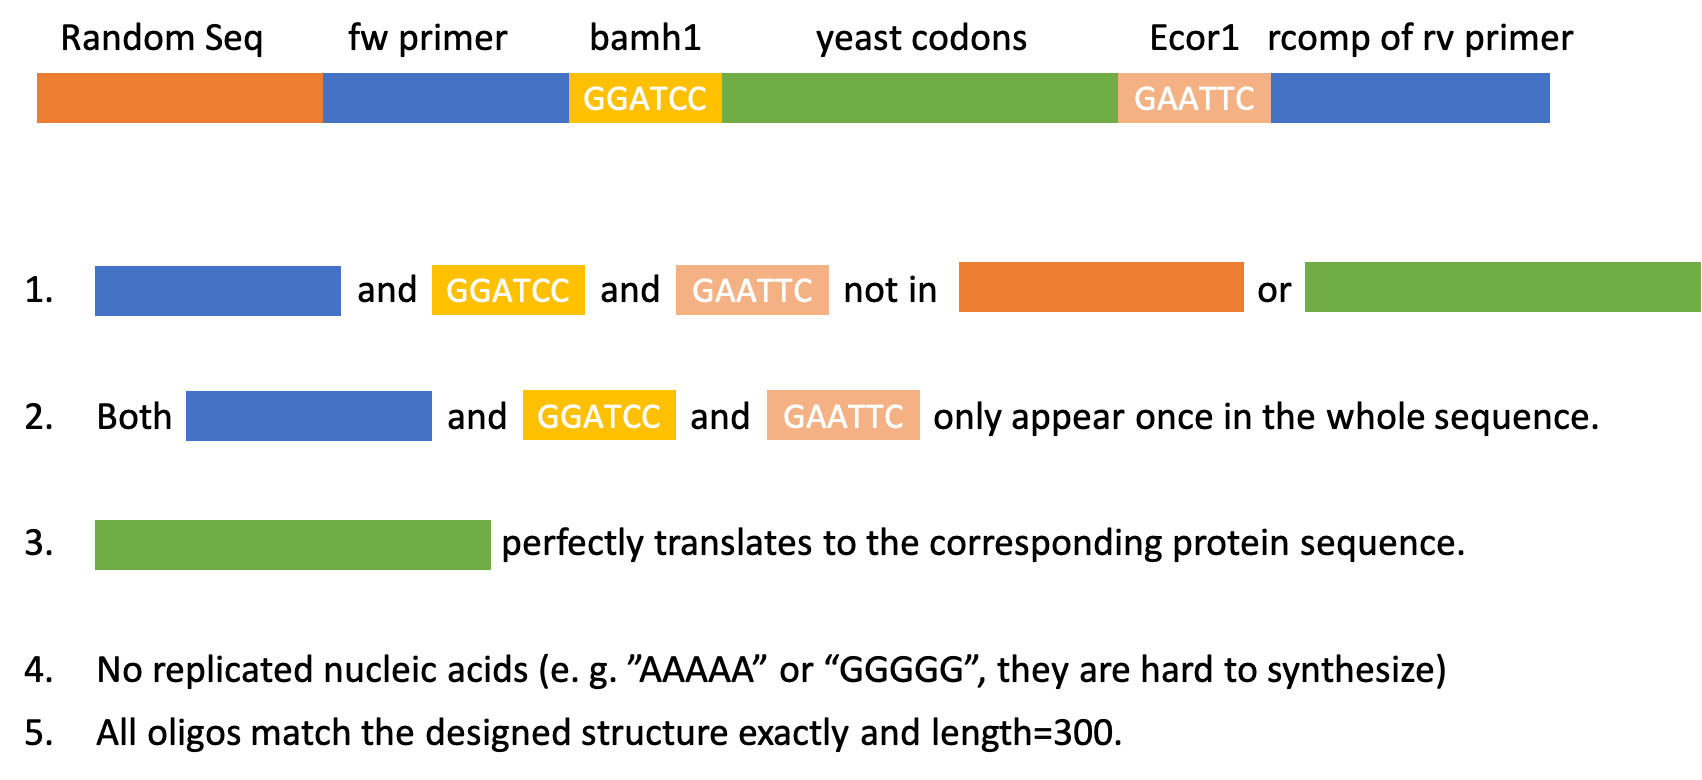

In [23]:
Image(filename='seq_structure_check.png') 

In [20]:
tmp = pd.read_excel('Outputs/oligo300.xls', header=None)
tmp_protein = get_seq('Outputs/Final_New_Proteins_tosubmit.fasta')
oligolist = [i for i in tmp.loc[:,1]]

In [21]:
for i in range(len(oligolist)):
    assert len(oligolist[i]) == 300
    for j in ['GGATCC', 'GAATTC', 'CCGGTTGTACCTATCGAGTGG', 'GAATTCGTACCTCTCCTTGCATGGTC']:
        assert oligolist[i].count(j)==1,i
    for j in ['GGGGG','AAAAA','TTTTT','CCCCC']:
        assert j not in oligolist[i]
        
    oligo = oligolist[i]
    frag_digest = oligo[oligo.find('CCGGTTGTACCTATCGAGTGGGATCC')+26 : oligo.find('GAATTCGTACCTCTCCTTGCATGGTC')]
    translate = Seq(frag_digest).translate()
    assert len(frag_digest)%3 ==0
    assert str(translate) == str(seqkeep[i]).replace('-','') # translated match protein

2. GC ratio

Max GC ratio = 0.61; Min GC ratio = 0.39


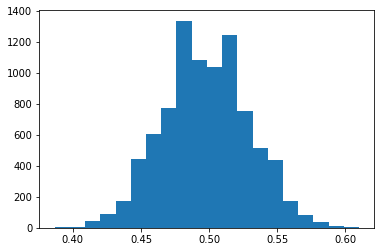

In [29]:
gc_ratio = []
for i in oligolist:
    r=(i.count('G')+i.count('C'))/300
    gc_ratio.append(r)
plt.hist(gc_ratio,20)
print('Max GC ratio = %.2f; Min GC ratio = %.2f' % (max(gc_ratio),min(gc_ratio)) )
plt.show()

3. Codon usage

In [34]:
frag_digest=[]
gene_split_new = []
for num, i in enumerate(oligolist):
    frag_digest.append(i[i.find('CCGGTTGTACCTATCGAGTGGGATCC')+26 : i.find('GAATTCGTACCTCTCCTTGCATGGTC')])
    length = int(len(frag_digest[num])/3)
    for j in range(length):
        gene_split_new.append(frag_digest[num][j*3:j*3+3])

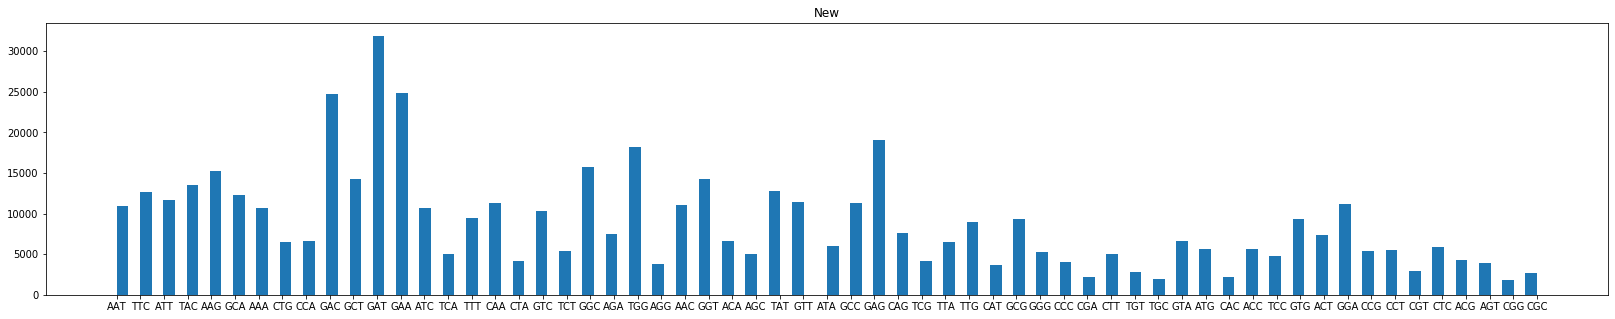

In [37]:
plt.figure(figsize=[28,5])
plt.hist(gene_split_new,bins=122)
plt.title('New')
plt.show()

In [42]:
gene_split_nat = [item for sublist in gene_split for item in sublist]

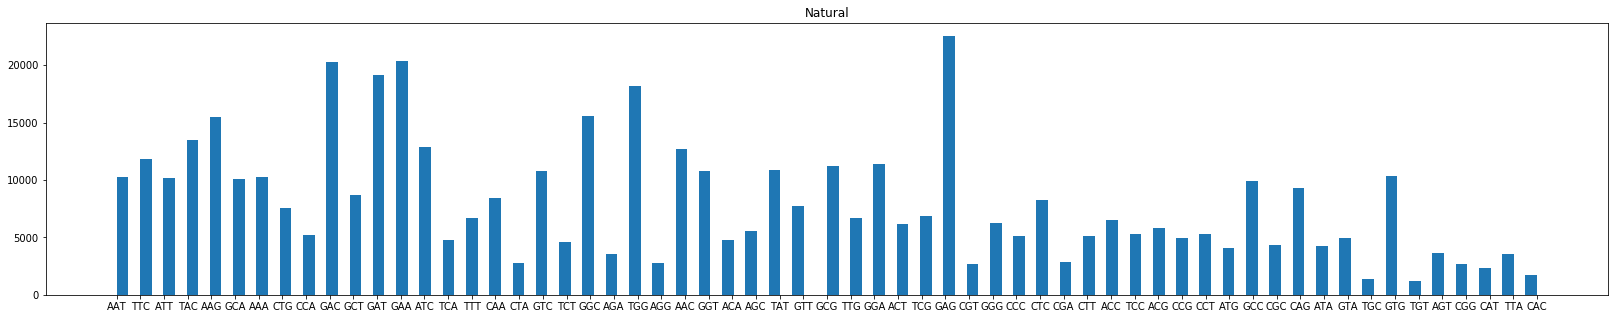

In [45]:
plt.figure(figsize=[28,5])
plt.hist(gene_split_nat,bins=122)
plt.title('Natural')
plt.show()

In [46]:
from collections import Counter
a=Counter(gene_split_nat)
b=Counter(gene_split_new)

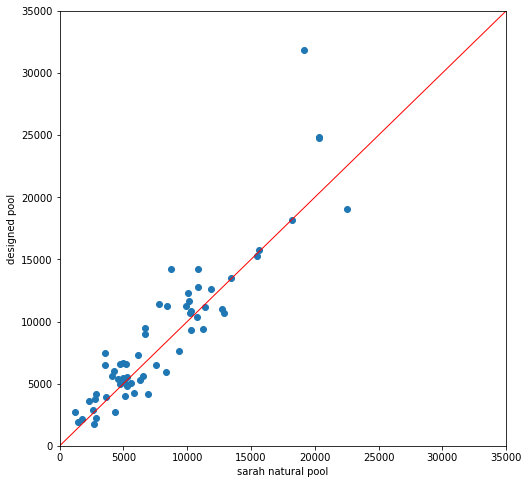

In [49]:
plt.figure(figsize=[8,8])
plt.scatter([i[1] for i in sorted(a.items())],[i[1] for i in sorted(b.items())])
plt.plot([0,35000],[0,35000],'r',lw=1)
plt.xlabel('sarah natural pool')
plt.ylabel('designed pool')
plt.xlim([0,35000])
plt.ylim([0,35000])
plt.show()